In [1]:
!pip install torch torchvision

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dar formato al dataset personalizado

In [4]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from torchvision.transforms import ToTensor # Nuevo import

class CocoaPestDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.images_root = os.path.join(root, 'train', 'images')
        self.labels_root = os.path.join(root, 'train', 'labels')
        self.image_files = sorted([f for f in os.listdir(self.images_root) if f.endswith('.jpg')])
        self.transforms = ToTensor() # Nuevo: Definir la transformación aquí

    def __getitem__(self, idx):
        # 1. Cargar la imagen
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_root, img_file)
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Nuevo: Aplicar la transformación para convertir la imagen a un tensor
        img_tensor = self.transforms(img)

        # 2. Cargar las etiquetas del archivo .txt
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.labels_root, label_file)

        boxes = []
        labels = []

        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()

                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # 3. Lógica de conversión de YOLO a Faster R-CNN
                xmin = int((center_x - width / 2) * img_width)
                ymin = int((center_y - height / 2) * img_height)
                xmax = int((center_x + width / 2) * img_width)
                ymax = int((center_y + height / 2) * img_height)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        # 4. Crear los tensores de PyTorch
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return img_tensor, target # Importante: devolver el tensor de la imagen

    def __len__(self):
        return len(self.image_files)

In [5]:
def get_model_instance_segmentation(num_classes):
    # Carga un modelo pre-entrenado en COCO
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Obtiene el número de características de entrada para el clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Reemplaza el clasificador de la cabeza del modelo por uno nuevo
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Define el número de clases (tus 3 plagas + 1 de fondo)
num_classes = 3 + 1
model = get_model_instance_segmentation(num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth


100%|██████████| 167M/167M [00:01<00:00, 170MB/s]


##Entrenamiento del modelo

In [7]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from torchvision.transforms import ToTensor

# clase CocoaPestDataset
class CocoaPestDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.images_root = os.path.join(root, 'train', 'images')
        self.labels_root = os.path.join(root, 'train', 'labels')
        self.image_files = sorted([f for f in os.listdir(self.images_root) if f.endswith('.jpg')])
        self.transforms = ToTensor() # Nuevo: Definir la transformación aquí

    def __getitem__(self, idx):
        # 1. Cargar la imagen
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_root, img_file)
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Nuevo: Aplicar la transformación para convertir la imagen a un tensor
        img_tensor = self.transforms(img)

        # 2. Cargar las etiquetas del archivo .txt
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.labels_root, label_file)

        boxes = []
        labels = []

        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()

                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # 3. Lógica de conversión de YOLO a Faster R-CNN
                xmin = int((center_x - width / 2) * img_width)
                ymin = int((center_y - height / 2) * img_height)
                xmax = int((center_x + width / 2) * img_width)
                ymax = int((center_y + height / 2) * img_height)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        # 4. Crear los tensores de PyTorch
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        return img_tensor, target # Importante: devolver el tensor de la imagen

    def __len__(self):
        return len(self.image_files)

# Función para agrupar los datos en un lote
def collate_fn(batch):
    return tuple(zip(*batch))

# Carga el dataset
dataset = CocoaPestDataset(root='/content/drive/MyDrive/EnfermedadesCacao')

# Carga el DataLoader usando la nueva función collate_fn
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn # ¡Este es el cambio clave!
)

# Define el optimizador y el planificador de tasa de aprendizaje
def get_model_instance_segmentation(num_classes):
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Define el número de clases (tus 3 plagas + 1 de fondo)
num_classes = 3 + 1
model = get_model_instance_segmentation(num_classes)

# Mover el modelo a la GPU
model.to(torch.device('cuda'))

# Define el optimizador y el planificador de tasa de aprendizaje
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Bucle de entrenamiento
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader:
        i += 1

        # Mueve los datos a la GPU (esto ya lo estabas haciendo)
        images = list(image.to(torch.device('cuda')) for image in images)
        targets = [{k: v.to(torch.device('cuda')) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iteration {i}, Loss: {losses.item()}")

Epoch 0, Iteration 10, Loss: 0.7045581340789795
Epoch 0, Iteration 20, Loss: 1.034045696258545
Epoch 0, Iteration 30, Loss: 0.5708919167518616
Epoch 0, Iteration 40, Loss: 0.48796209692955017
Epoch 0, Iteration 50, Loss: 0.5342521071434021
Epoch 0, Iteration 60, Loss: 0.34715813398361206
Epoch 0, Iteration 70, Loss: 0.2828339636325836
Epoch 0, Iteration 80, Loss: 0.3144146502017975
Epoch 0, Iteration 90, Loss: 0.6341116428375244
Epoch 0, Iteration 100, Loss: 0.30487188696861267
Epoch 0, Iteration 110, Loss: 0.5695534348487854
Epoch 1, Iteration 10, Loss: 0.2641887068748474
Epoch 1, Iteration 20, Loss: 0.3579545021057129
Epoch 1, Iteration 30, Loss: 0.6095008254051208
Epoch 1, Iteration 40, Loss: 1.174737572669983
Epoch 1, Iteration 50, Loss: 0.5914812684059143
Epoch 1, Iteration 60, Loss: 0.42089036107063293
Epoch 1, Iteration 70, Loss: 0.36601918935775757
Epoch 1, Iteration 80, Loss: 0.14790628850460052
Epoch 1, Iteration 90, Loss: 0.3384662866592407
Epoch 1, Iteration 100, Loss: 0.24

In [10]:
!pip install pycocotools

In [18]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2 as T
from PIL import Image
import os
import random
import copy

# Importaciones para la evaluación de COCO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# --- Definición de las Clases y Funciones ---

class CocoaPestDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode='train'):
        self.root = root
        self.images_root = os.path.join(root, mode, 'images')
        self.labels_root = os.path.join(root, mode, 'labels')
        self.image_files = sorted([f for f in os.listdir(self.images_root) if f.endswith('.jpg')])
        self.transforms = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

    def __getitem__(self, idx):
        # Cargar la imagen
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_root, img_file)
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Cargar las etiquetas del archivo .txt
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.labels_root, label_file)

        boxes = []
        labels = []

        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()

                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                xmin = int((center_x - width / 2) * img_width)
                ymin = int((center_y - height / 2) * img_height)
                xmax = int((center_x + width / 2) * img_width)
                ymax = int((center_y + height / 2) * img_height)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

def get_model_instance_segmentation(num_classes):
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

def convert_to_coco_format(dataset):
    coco_data = {
        "info": {}, # Clave 'info' agregada
        "licenses": [], # Clave 'licenses' agregada
        "images": [],
        "annotations": [],
        "categories": [{"id": i+1, "name": f"class_{i+1}"} for i in range(len(dataset.image_files))]
    }
    ann_id = 0
    for idx, (img, target) in enumerate(dataset):
        image_id = int(target["image_id"].item())
        coco_data["images"].append({
            "id": image_id,
            "height": img.shape[1],
            "width": img.shape[2],
            "file_name": dataset.image_files[idx]
        })

        for box, label, area in zip(target["boxes"], target["labels"], target["area"]):
            xmin, ymin, xmax, ymax = box.tolist()
            width = xmax - xmin
            height = ymax - ymin
            coco_data["annotations"].append({
                "id": ann_id,
                "image_id": image_id,
                "category_id": int(label.item()),
                "bbox": [xmin, ymin, width, height],
                "area": area.item(),
                "iscrowd": 0
            })
            ann_id += 1
    return coco_data

# --- Configuración y Evaluación ---

# Aquí se inicializa y se mueve el modelo a la GPU (debe haber sido entrenado previamente)
num_classes = 4  # Tus 3 clases + 1 de fondo
model = get_model_instance_segmentation(num_classes)
model.to(torch.device('cuda'))

# Cargar el dataset de validación
val_dataset = CocoaPestDataset(root='/content/drive/MyDrive/EnfermedadesCacao', mode='val')
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Poner el modelo en modo de evaluación
model.eval()

# Convertir tu dataset a un formato compatible con COCO API
coco_gt_data = convert_to_coco_format(val_dataset)
coco_gt = COCO()
coco_gt.dataset = coco_gt_data
coco_gt.createIndex()

# Obtener las predicciones del modelo
results = []
for images, targets in val_data_loader:
    images = list(img.to(torch.device('cuda')) for img in images)
    with torch.no_grad():
        outputs = model(images)

    for i, output in enumerate(outputs):
        image_id = int(targets[i]['image_id'].item())
        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            xmin, ymin, xmax, ymax = box.tolist()
            width = xmax - xmin
            height = ymax - ymin
            results.append({
                "image_id": image_id,
                "category_id": int(label.item()),
                "bbox": [xmin, ymin, width, height],
                "score": score.item()
            })

# Evaluar las predicciones
coco_dt = coco_gt.loadRes(results)
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.23s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.020
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.037
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.

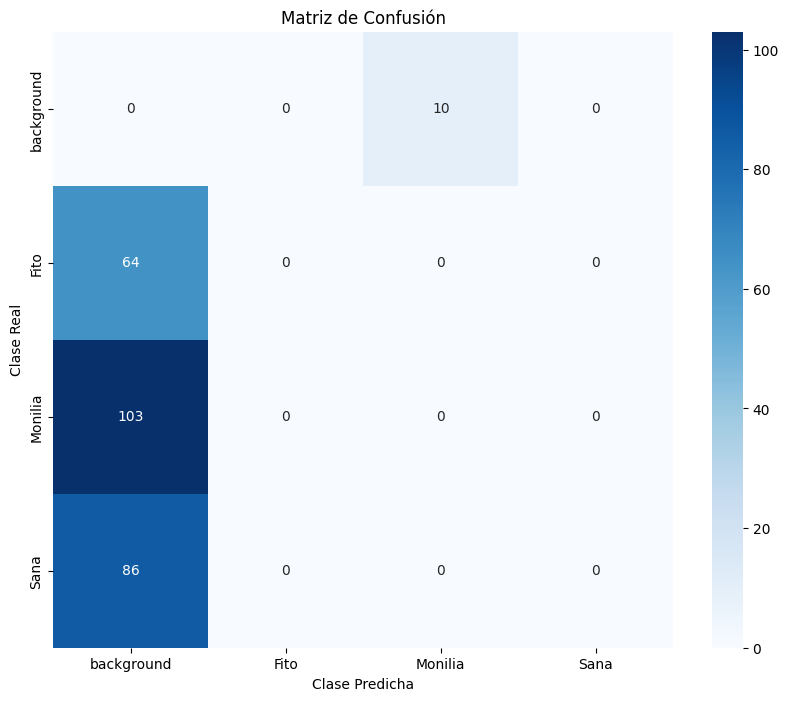

In [21]:
import torch
import torch.utils.data
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import v2 as T
from PIL import Image
import os
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

# Importaciones para la evaluación de COCO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# --- Definición de las Clases y Funciones ---

class CocoaPestDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode='train'):
        self.root = root
        self.images_root = os.path.join(root, mode, 'images')
        self.labels_root = os.path.join(root, mode, 'labels')
        self.image_files = sorted([f for f in os.listdir(self.images_root) if f.endswith('.jpg')])
        self.transforms = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

    def __getitem__(self, idx):
        # Cargar la imagen
        img_file = self.image_files[idx]
        img_path = os.path.join(self.images_root, img_file)
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Cargar las etiquetas del archivo .txt
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.labels_root, label_file)

        boxes = []
        labels = []

        if os.path.exists(label_path) and os.stat(label_path).st_size > 0:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                parts = line.strip().split()

                class_id = int(parts[0])
                center_x = float(parts[1])
                center_y = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                xmin = int((center_x - width / 2) * img_width)
                ymin = int((center_y - height / 2) * img_height)
                xmax = int((center_x + width / 2) * img_width)
                ymax = int((center_y + height / 2) * img_height)

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id + 1)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.image_files)

def get_model_instance_segmentation(num_classes):
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# --- Configuración y Evaluación ---

# Aquí se inicializa y se mueve el modelo a la GPU (debe haber sido entrenado previamente)
num_classes = 4  # Tus 3 clases + 1 de fondo
model = get_model_instance_segmentation(num_classes)
model.to(torch.device('cuda'))

# Cargar el dataset de validación
val_dataset = CocoaPestDataset(root='/content/drive/MyDrive/EnfermedadesCacao', mode='val')
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Poner el modelo en modo de evaluación
model.eval()

# Lista para almacenar los pares de (targets, outputs)
eval_results = []
cpu_device = torch.device("cpu")

# Bucle de predicción corregido
for images, targets in val_data_loader:
    images = list(img.to(torch.device('cuda')) for img in images)
    with torch.no_grad():
        outputs = model(images)

    # Mover los resultados a CPU para un procesamiento más fácil
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    targets_on_cpu = [{k: v.to(cpu_device) for k, v in t.items()} for t in targets]

    # Guardar los pares de (targets, outputs)
    eval_results.append((targets_on_cpu, outputs))

# --- Generar la Matriz de Confusión ---

# Definir las clases para la matriz
class_names = ['background', 'Fito', 'Monilia', 'Sana']
num_classes = len(class_names)

# Inicializar la matriz de confusión
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Umbral de IoU y de confianza
iou_threshold = 0.5
score_threshold = 0.5

# Diccionario para rastrear qué anotaciones ya han sido emparejadas
matched_annotations = {}

# Recorrer los resultados de la evaluación (ahora están en el formato correcto)
for targets, outputs in eval_results:
    for i, target in enumerate(targets):
        image_id = target['image_id'].item()

        gt_boxes = target['boxes']
        gt_labels = target['labels']

        pred_boxes = outputs[i]['boxes']
        pred_labels = outputs[i]['labels']
        pred_scores = outputs[i]['scores']

        # Filtrar predicciones por umbral de confianza
        high_score_indices = pred_scores >= score_threshold
        pred_boxes = pred_boxes[high_score_indices]
        pred_labels = pred_labels[high_score_indices]

        # Iniciar el seguimiento de anotaciones para esta imagen
        matched_annotations[image_id] = [False] * len(gt_boxes)

        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes).cpu().numpy()

            for p_idx in range(len(pred_boxes)):
                if not gt_boxes.nelement():  # Si no hay cajas verdaderas
                    confusion_matrix[0][pred_labels[p_idx].item()] += 1
                    continue

                max_iou_gt_idx = np.argmax(iou_matrix[:, p_idx])
                max_iou = iou_matrix[max_iou_gt_idx, p_idx]

                if max_iou >= iou_threshold:
                    gt_label = gt_labels[max_iou_gt_idx].item()
                    pred_label = pred_labels[p_idx].item()

                    if not matched_annotations[image_id][max_iou_gt_idx]:
                        # Verdadero Positivo (VP)
                        confusion_matrix[gt_label][pred_label] += 1
                        matched_annotations[image_id][max_iou_gt_idx] = True
                    else:
                        # Falso Positivo (FP) - Múltiples predicciones para la misma anotación
                        confusion_matrix[0][pred_label] += 1
                else:
                    # Falso Positivo (FP) - Predicción que no coincide con ninguna anotación real
                    confusion_matrix[0][pred_labels[p_idx].item()] += 1

        # Contar los Falsos Negativos (FN)
        for gt_idx in range(len(gt_boxes)):
            if not matched_annotations[image_id][gt_idx]:
                confusion_matrix[gt_labels[gt_idx].item()][0] += 1

# --- Visualizar la Matriz de Confusión ---
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Real')
plt.xlabel('Clase Predicha')
plt.show()

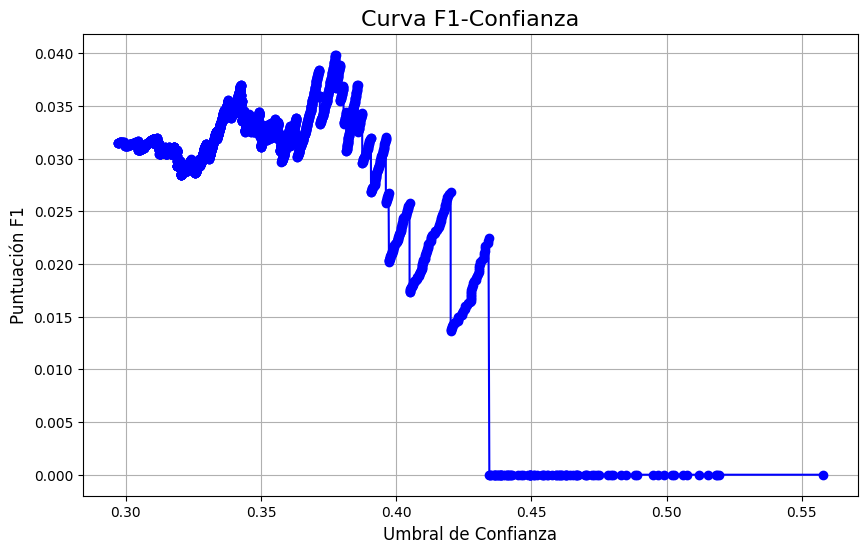

El F1 máximo es 0.0399 en un umbral de confianza de 0.3776


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

# --- Generar los datos para la Curva F1-Confianza ---

# Umbral de IoU para considerar una detección como "correcta"
iou_threshold = 0.5

# Lista para almacenar todas las predicciones y sus resultados
all_preds = []

# Recorrer los resultados de la evaluación (eval_results)
for targets, outputs in eval_results:
    for i, target in enumerate(targets):
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        pred_boxes = outputs[i]['boxes']
        pred_labels = outputs[i]['labels']
        pred_scores = outputs[i]['scores']

        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)

            # Asignar cada predicción a la mejor anotación verdadera
            for p_idx in range(len(pred_boxes)):
                # Encontrar la anotación con el mayor IoU
                max_iou_gt_idx = torch.argmax(iou_matrix[:, p_idx])
                max_iou = iou_matrix[max_iou_gt_idx, p_idx]

                # Obtener la etiqueta verdadera y predicha
                gt_label = gt_labels[max_iou_gt_idx].item()
                pred_label = pred_labels[p_idx].item()

                # Determinar si es un VP, FP o FN
                is_tp = (max_iou >= iou_threshold) and (gt_label == pred_label)

                all_preds.append({
                    'score': pred_scores[p_idx].item(),
                    'is_tp': is_tp,
                    'is_fp': not is_tp,
                    'is_fn': False # Falsos negativos se cuentan por separado
                })

        # Contar Falsos Negativos
        if len(gt_boxes) > len(pred_boxes):
            num_fns = len(gt_boxes) - len(pred_boxes)
            for _ in range(num_fns):
                 all_preds.append({
                    'score': 0, # Un FN no tiene confianza, se le asigna 0
                    'is_tp': False,
                    'is_fp': False,
                    'is_fn': True
                })


# Ordenar todas las predicciones por score de mayor a menor
all_preds.sort(key=lambda x: x['score'], reverse=True)

# Acumular los VPs, FPs y FNs
total_tp = 0
total_fp = 0
total_fn = 0
f1_scores = []
conf_thresholds = []

for i, pred in enumerate(all_preds):
    if pred['is_tp']:
        total_tp += 1
    elif pred['is_fp']:
        total_fp += 1
    elif pred['is_fn']:
        total_fn += 1

    # Calcular Precisión, Recall y F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    f1_scores.append(f1)
    conf_thresholds.append(pred['score'])

# --- Visualizar la Curva F1-Confianza ---

plt.figure(figsize=(10, 6))
plt.plot(conf_thresholds, f1_scores, marker='o', linestyle='-', color='b')
plt.title('Curva F1-Confianza', fontsize=16)
plt.xlabel('Umbral de Confianza', fontsize=12)
plt.ylabel('Puntuación F1', fontsize=12)
plt.grid(True)
plt.show()

# Opcional: Encontrar el punto de F1 máximo
max_f1 = max(f1_scores)
max_f1_idx = f1_scores.index(max_f1)
optimal_conf = conf_thresholds[max_f1_idx]

print(f"El F1 máximo es {max_f1:.4f} en un umbral de confianza de {optimal_conf:.4f}")

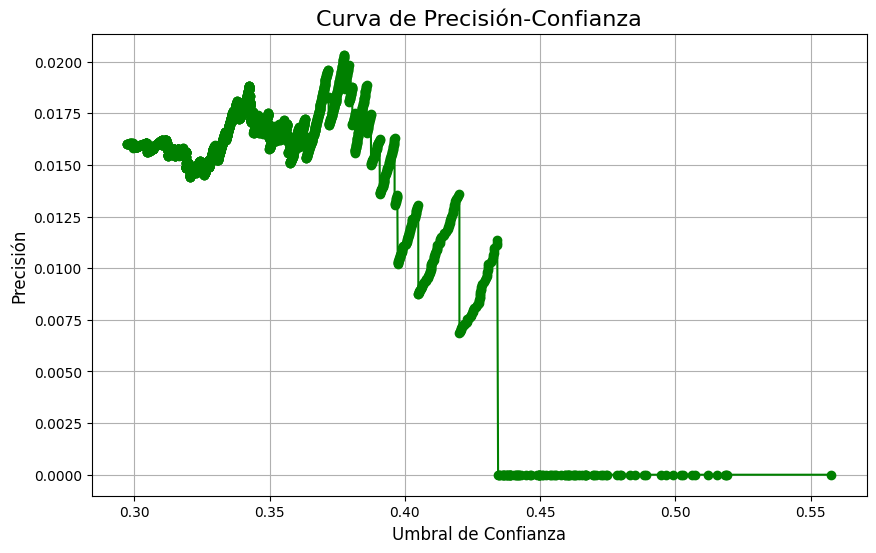

La precisión a un umbral de confianza de 0.5 es aproximadamente 0.0000


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch

# --- Generar los datos para la Curva de Precisión-Confianza ---

# Umbral de IoU para considerar una detección como "correcta"
iou_threshold = 0.5

# Lista para almacenar todas las predicciones y sus resultados
all_preds_precision = []

# Recorrer los resultados de la evaluación (eval_results)
for targets, outputs in eval_results:
    for i, target in enumerate(targets):
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        pred_boxes = outputs[i]['boxes']
        pred_labels = outputs[i]['labels']
        pred_scores = outputs[i]['scores']

        if len(gt_boxes) > 0 and len(pred_boxes) > 0:
            iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)

            # Asignar cada predicción a la mejor anotación verdadera
            for p_idx in range(len(pred_boxes)):
                # Encontrar la anotación con el mayor IoU
                max_iou_gt_idx = torch.argmax(iou_matrix[:, p_idx])
                max_iou = iou_matrix[max_iou_gt_idx, p_idx]

                # Obtener la etiqueta verdadera y predicha
                gt_label = gt_labels[max_iou_gt_idx].item()
                pred_label = pred_labels[p_idx].item()

                # Determinar si es un VP o un FP
                is_tp = (max_iou >= iou_threshold) and (gt_label == pred_label)

                all_preds_precision.append({
                    'score': pred_scores[p_idx].item(),
                    'is_tp': is_tp,
                    'is_fp': not is_tp,
                })

# Ordenar todas las predicciones por score de mayor a menor
all_preds_precision.sort(key=lambda x: x['score'], reverse=True)

# Acumular los VPs y FPs
total_tp = 0
total_fp = 0
precision_scores = []
conf_thresholds = []

for pred in all_preds_precision:
    if pred['is_tp']:
        total_tp += 1
    elif pred['is_fp']:
        total_fp += 1

    # Calcular Precisión
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0

    precision_scores.append(precision)
    conf_thresholds.append(pred['score'])

# --- Visualizar la Curva de Precisión-Confianza ---

plt.figure(figsize=(10, 6))
plt.plot(conf_thresholds, precision_scores, marker='o', linestyle='-', color='g')
plt.title('Curva de Precisión-Confianza', fontsize=16)
plt.xlabel('Umbral de Confianza', fontsize=12)
plt.ylabel('Precisión', fontsize=12)
plt.grid(True)
plt.show()

# Opcional: Encontrar la precisión a un umbral específico
target_conf_threshold = 0.5  # Por ejemplo, para un umbral de 0.5
for i, score in enumerate(conf_thresholds):
    if score <= target_conf_threshold:
        print(f"La precisión a un umbral de confianza de {target_conf_threshold} es aproximadamente {precision_scores[i]:.4f}")
        break